In [1]:
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from scipy import stats

In [4]:
from sklearn.metrics import mean_squared_error, explained_variance_score

## Load Data

In [5]:
data = pd.read_csv('Data_Files/train.csv')
data.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,2ZR62O53,6196161750,215250,222720,27716,3246298,1734810,93036735,1,0,English
1,ZJ31SS7Q,6091677300,211845,310998,25610,5310163,1370184,89705964,1,0,English
2,I31VI9RK,5644590915,515280,387315,10976,1767635,1023779,102611607,1,1,Portuguese
3,6GP9WLYR,3970318140,517740,300575,7714,3944850,703986,106546942,1,0,English
4,3DVR0TDD,3671000070,123660,285644,29602,8938903,2068424,78998587,1,0,English


## Data Preprocessing

### Add a constant for eliminating negative values

In [6]:
data['Followers gained'].min()

-15772

In [7]:
numeric = data.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196161750,215250,222720,27716,3246298,1734810,93036735
1,6091677300,211845,310998,25610,5310163,1370184,89705964
2,5644590915,515280,387315,10976,1767635,1023779,102611607
3,3970318140,517740,300575,7714,3944850,703986,106546942
4,3671000070,123660,285644,29602,8938903,2068424,78998587


In [8]:
numeric += 15772

In [9]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,6196177522,231022,238492,43488,3262070,1750582,93052507
1,6091693072,227617,326770,41382,5325935,1385956,89721736
2,5644606687,531052,403087,26748,1783407,1039551,102627379
3,3970333912,533512,316347,23486,3960622,719758,106562714
4,3671015842,139432,301416,45374,8954675,2084196,79014359


In [10]:
numeric['Followers gained'].min()

0

In [11]:
for col in numeric.columns:
    print(f"{col}: {numeric[col].min()}\n")

Watch time(Minutes): 154539937

Stream time(minutes): 21967

Peak viewers: 16954

Average viewers: 16085

Followers: 19432

Followers gained: 0

Views gained: 191560



### Log transformation

In [12]:
numeric = numeric.transform(np.log)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained
0,22.547198,12.350268,12.382091,10.680240,14.997873,14.375459,18.348674
1,22.530192,12.335420,12.697012,10.630601,15.488099,14.141901,18.312224
2,22.453966,13.182615,12.906908,10.194215,14.394036,13.854299,18.446615
3,22.102116,13.187237,12.664595,10.064160,15.191912,13.486670,18.484244
4,22.023734,11.845332,12.616247,10.722695,16.007686,14.549894,18.185140


### Remove outliers

In [13]:
sns.set_theme(style='whitegrid')

In [14]:
def remove_outliers(x):
    global numeric
    data_var = numeric[x]
    
    Q75, Q25 = np.percentile(data_var, [75, 25])
    IQR = Q75 - Q25
    lower_bound = Q25 - (1.5*IQR)
    upper_bound = Q75 + (1.5*IQR)
    
    numeric = numeric[(numeric[x] >= lower_bound) & (numeric[x] <= upper_bound)].reset_index()
    numeric.drop('index', axis=1, inplace=True)
    
    print(f'{numeric.info()}\n')

In [15]:
for col in numeric.columns:
    remove_outliers(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   783 non-null    float64
 1   Stream time(minutes)  783 non-null    float64
 2   Peak viewers          783 non-null    float64
 3   Average viewers       783 non-null    float64
 4   Followers             783 non-null    float64
 5   Followers gained      783 non-null    float64
 6   Views gained          783 non-null    float64
dtypes: float64(7)
memory usage: 42.9 KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   731 non-null    float64
 1   Stream time(minutes)  731 non-null    float64
 2   Peak viewers          731 non-null    float64
 3   Average viewers       731 

### Polynomial Regression

In [17]:
equations = {}

fg = 'Followers gained'

def display_reg(x, y, degree=3):
    fig, ax = plt.subplots(figsize=(20,16))
    
    horizontal = np.linspace(numeric[x].min(), numeric[x].max(), len(numeric[x]))
    function_model = np.poly1d(np.polyfit(numeric[x].values, numeric[y].values, degree))
    
    equations[y] = function_model
    
    plt.scatter(data=numeric, x=x, y=y, zorder=1)
    plt.plot(horizontal, function_model(horizontal), zorder=2, color='r')
    
    plt.xlabel(x)
    plt.ylabel(y)
    
    plt.show()

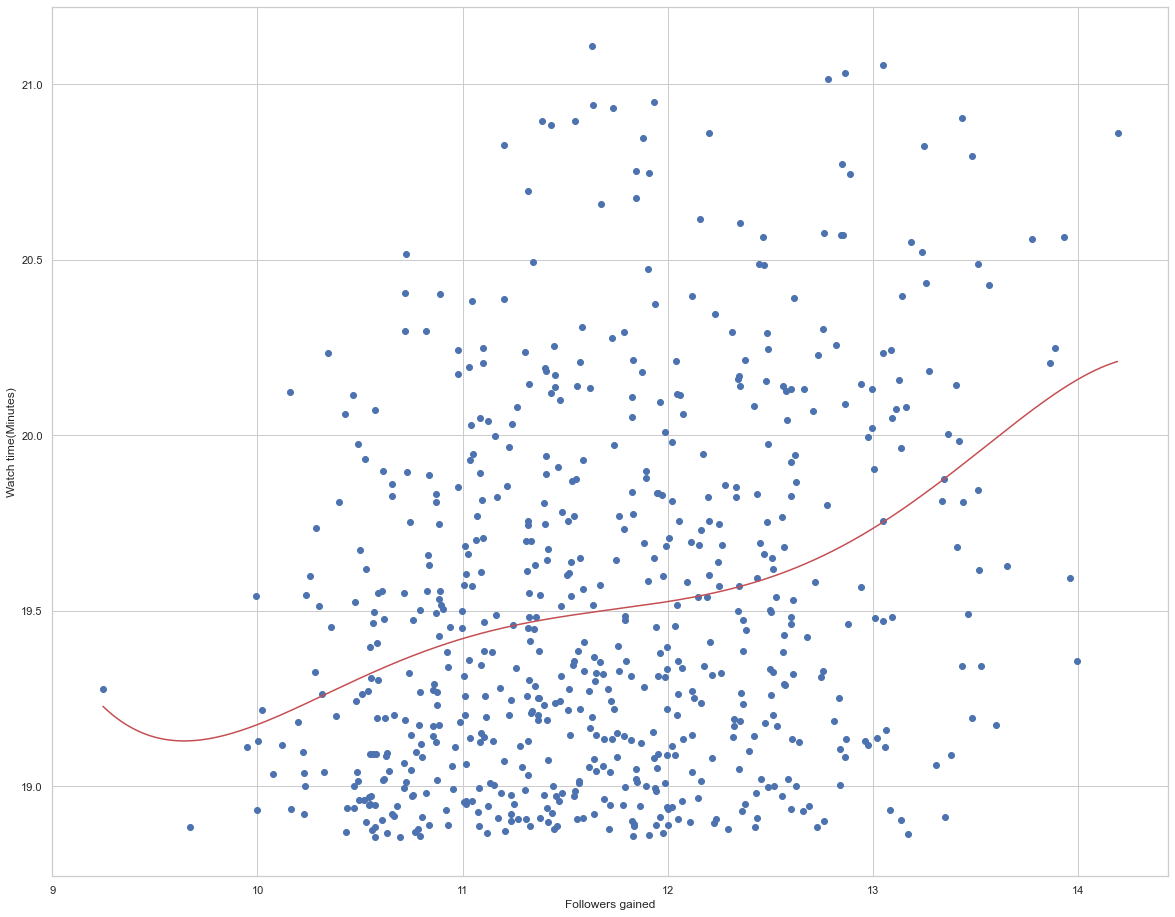

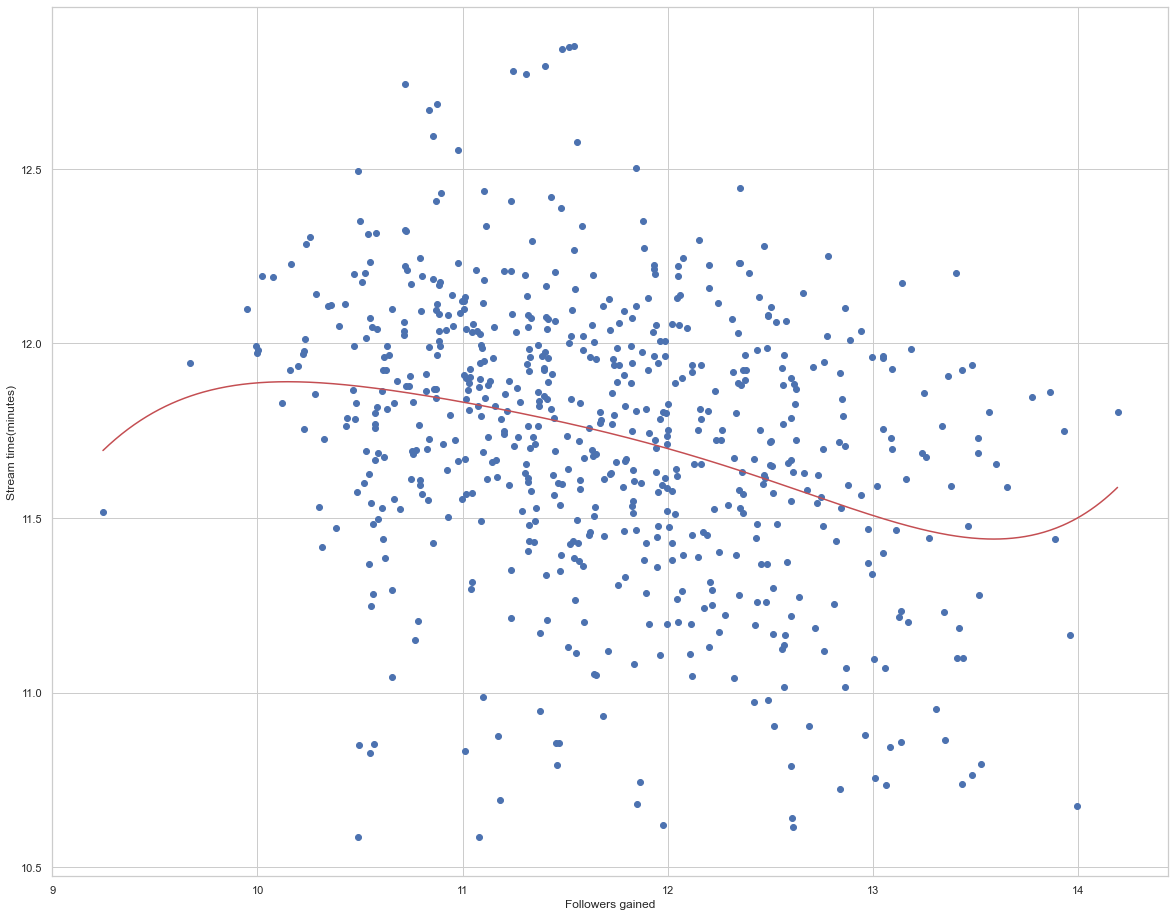

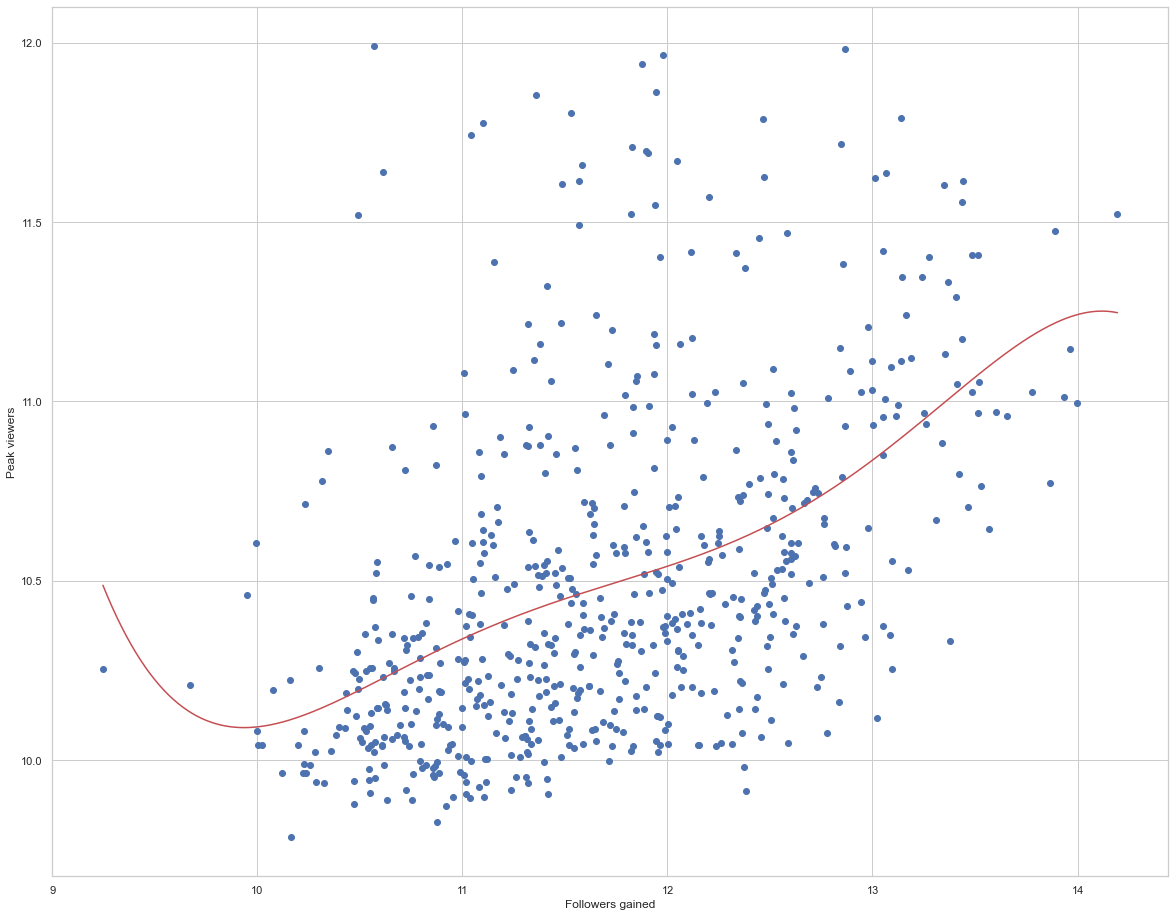

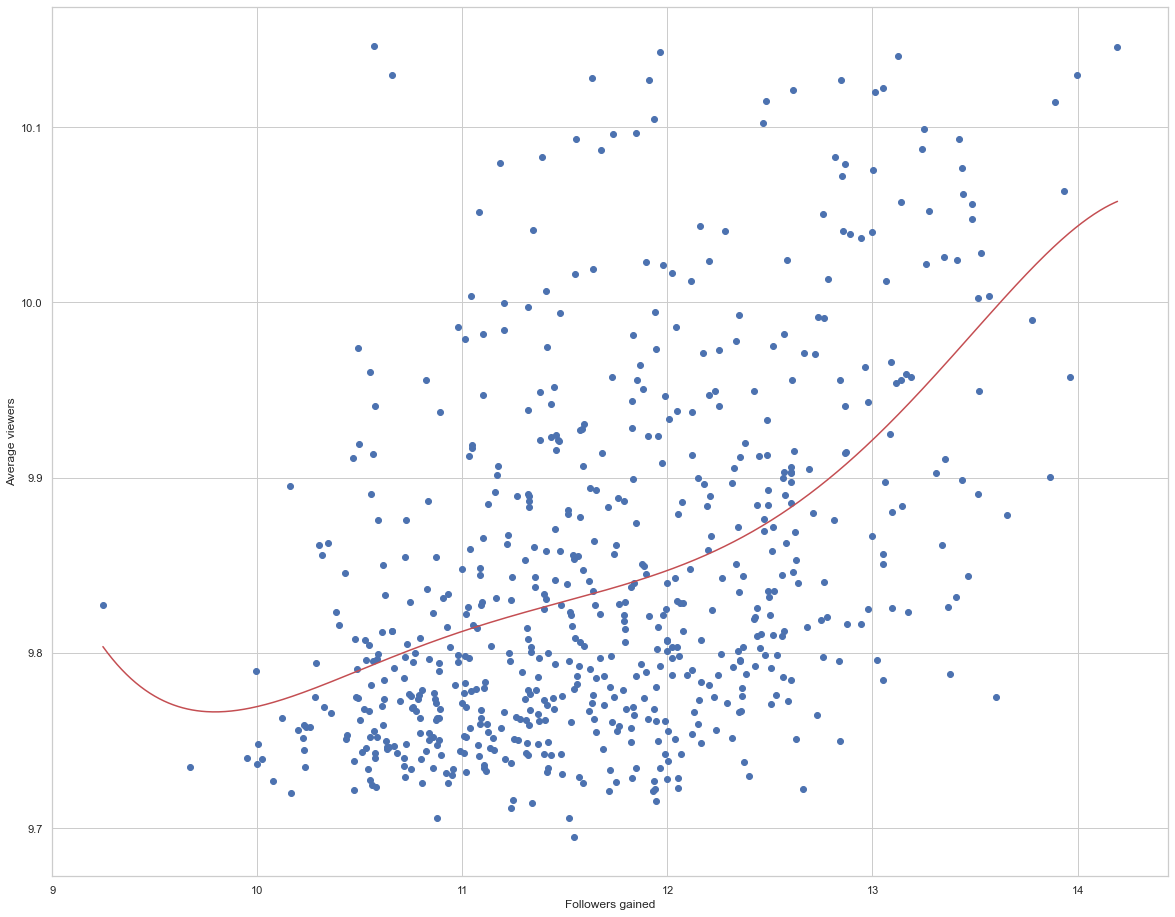

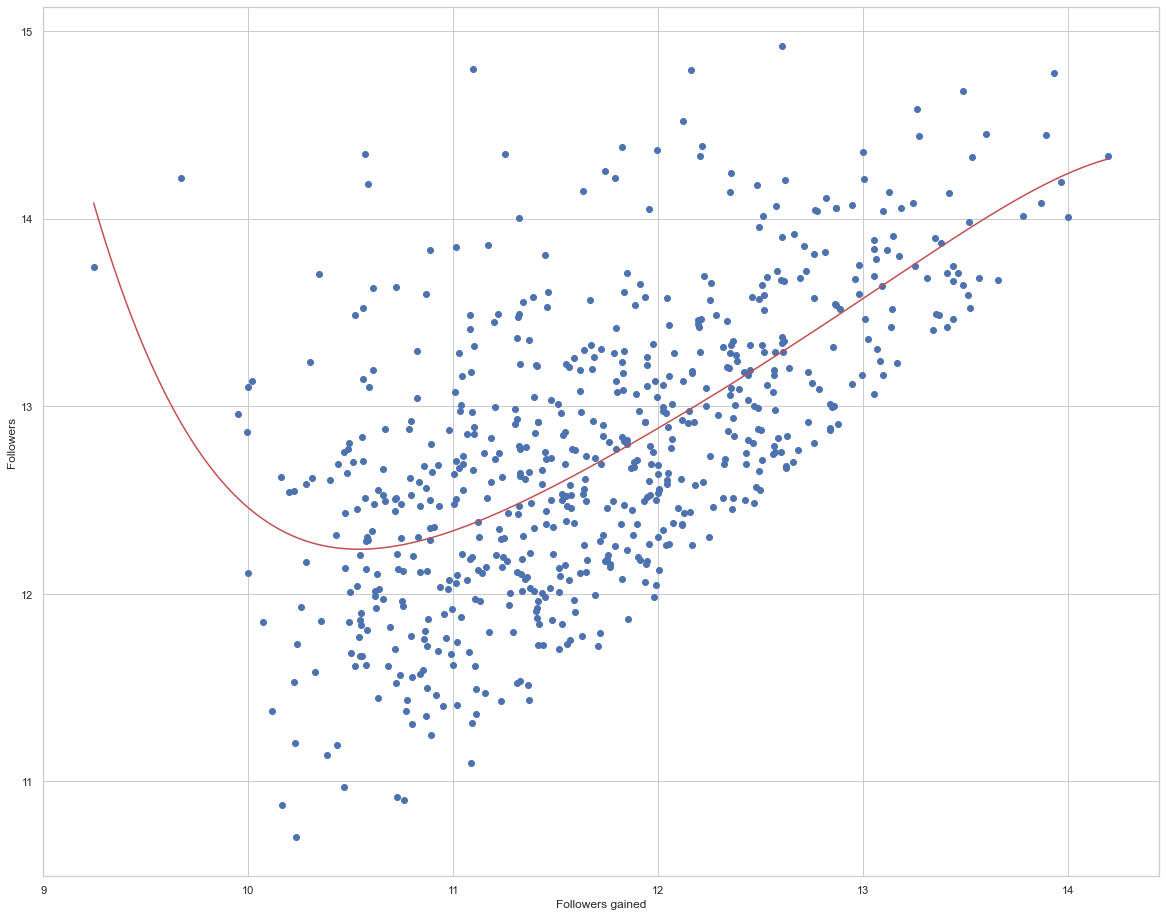

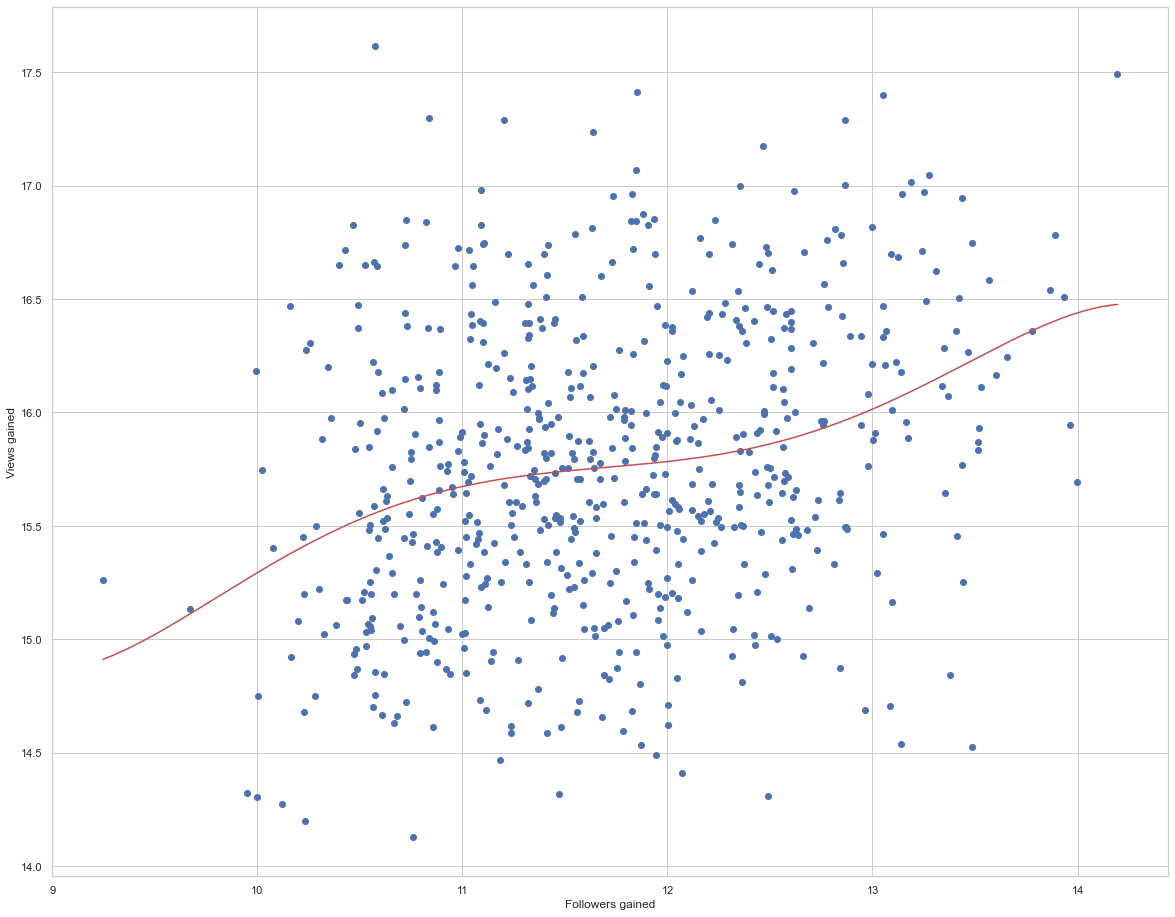

In [18]:
y_columns = numeric.drop('Followers gained', axis=1).columns

for y in y_columns:
    display_reg(fg, y, 5)

In [19]:
equations

{'Watch time(Minutes)': poly1d([-8.42754278e-03,  5.00371835e-01, -1.18103503e+01,  1.38535700e+02,
        -8.07494690e+02,  1.88993869e+03]),
 'Stream time(minutes)': poly1d([ 4.60067138e-03, -2.66747376e-01,  6.17776670e+00, -7.14679880e+01,
         4.13030960e+02, -9.41983824e+02]),
 'Peak viewers': poly1d([-1.16837925e-02,  6.96053727e-01, -1.65147386e+01,  1.95087726e+02,
        -1.14729648e+03,  2.69686504e+03]),
 'Average viewers': poly1d([-1.90553110e-03,  1.12661664e-01, -2.64962893e+00,  3.09960661e+01,
        -1.80375514e+02,  4.27483304e+02]),
 'Followers': poly1d([-8.72146341e-03,  5.38135469e-01, -1.32858819e+01,  1.64106977e+02,
        -1.01377537e+03,  2.51618884e+03]),
 'Views gained': poly1d([-7.68038929e-03,  4.47585833e-01, -1.03473950e+01,  1.18582861e+02,
        -6.73223311e+02,  1.52881694e+03])}

### Artificial Data Generation based on retrieved regression

In [20]:
cols = ['Watch time(Minutes)', 'Stream time(minutes)', 'Peak viewers', 
        'Average viewers', 'Followers', 'Views gained', 'Followers gained']

numeric = numeric.reindex(columns=cols)
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329


In [23]:
fg = numeric['Followers gained']

raf = []
aug_data = pd.DataFrame()

while (len(raf) < 2*(10**3)):
    rand_fg = np.random.randint(fg.min(), fg.max())
    raf.append(rand_fg)
        
for key in equations:
    values = [(equations[key](fg)) for fg in raf]
    aug_data[key] = values

aug_data['Followers gained'] = raf
numeric = numeric.append(aug_data)

numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Watch time(Minutes)   2649 non-null   float64
 1   Stream time(minutes)  2649 non-null   float64
 2   Peak viewers          2649 non-null   float64
 3   Average viewers       2649 non-null   float64
 4   Followers             2649 non-null   float64
 5   Views gained          2649 non-null   float64
 6   Followers gained      2649 non-null   float64
dtypes: float64(7)
memory usage: 165.6 KB


## Feature Engineering

In [24]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329


<AxesSubplot:>

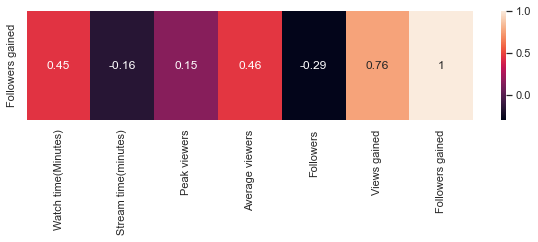

In [27]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [28]:
# How much each viewer spends time in watching the stream?
numeric['Watch time(Minutes)/Average viewers'] = numeric['Watch time(Minutes)'] / numeric['Average viewers']

# If all the followers viewed the stream, how much time would each of them spend?
numeric['Watch time(Minutes)/Followers'] = numeric['Watch time(Minutes)'] / numeric['Followers']

# What proportion of Peak viewers is out of total Followers?
numeric['Peak viewers/Followers'] = numeric['Peak viewers'] / numeric['Followers']

# What proportion of Average viewers is out of total Followers?
numeric['Average viewers/Followers'] = numeric['Average viewers'] / numeric['Followers']

# How much views will be optained from a single minute of streaming?
numeric['Views gained/Stream time(minutes)'] = numeric['Views gained'] / numeric['Stream time(minutes)']

<AxesSubplot:>

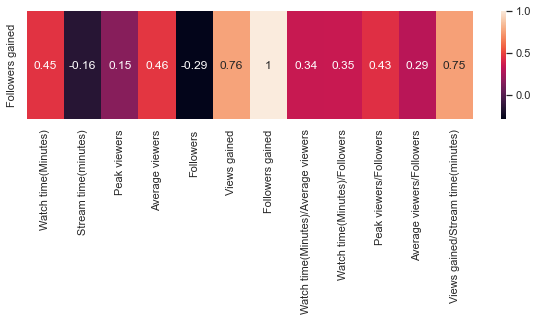

In [29]:
extracted = pd.DataFrame(numeric.corr().loc['Followers gained']).transpose()

figure, ax = plt.subplots(figsize=(10,2))
figure.set_facecolor('white')
sns.heatmap(ax=ax, data=extracted, annot=True)

In [30]:
numeric.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Followers gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,21.109149,12.053312,10.716371,10.127750,14.148330,16.813730,11.631286,2.084288,1.491989,0.757430,0.715827,1.394947
1,21.055679,11.964364,10.851374,10.122181,13.839043,17.398859,13.051765,2.080152,1.521469,0.784113,0.731422,1.454223
2,21.031515,12.100751,11.981916,10.079036,13.544537,17.289888,12.863929,2.086659,1.552767,0.884631,0.744140,1.428828
3,21.015458,12.251677,11.009092,10.013014,13.093748,16.466689,12.784320,2.098814,1.604999,0.840790,0.764717,1.344036
4,20.948589,11.963409,11.187486,10.104590,12.917791,16.855177,11.936329,2.073176,1.621685,0.866053,0.782223,1.408894


## Train, Test, Val Split & Data Scaling

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [32]:
X = numeric.drop('Followers gained', axis=1).values
y = numeric['Followers gained'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=101)

In [34]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

## Models Generation

In [42]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Deep Neural Network

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend as K
from keras.losses import mean_squared_error as mse

In [36]:
model = Sequential()

# INPUT LAYER
model.add(Dense(512, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# FIRST DENSE LAYER
model.add(Dense(512, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# SECOND DENSE LAYER
model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# THIRD DENSE LAYER
model.add(Dense(256, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# FOURTH DENSE LAYER
model.add(Dense(128, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# FIFTH DENSE LAYER
model.add(Dense(128, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# SIXTH DENSE LAYER
model.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# SEVENTH DENSE LAYER
model.add(Dense(64, activation='relu', kernel_initializer=keras.initializers.RandomUniform()))
model.add(Dropout(0.5))

# OUTPUT LAYER
model.add(Dense(1))

# COMPILE MODEL
def rmse(y_true, y_pred):
    return K.sqrt(mse(y_true, y_pred))

model.compile(optimizer='adam', loss=rmse)

In [37]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=70)

Epoch 1/70
67/67 [==============================] - 1s 8ms/step - loss: 6.5255 - val_loss: 3.3013
Epoch 2/70
67/67 [==============================] - 0s 7ms/step - loss: 3.5166 - val_loss: 1.2849
Epoch 3/70
67/67 [==============================] - 0s 6ms/step - loss: 3.0608 - val_loss: 0.7994
Epoch 4/70
67/67 [==============================] - 0s 6ms/step - loss: 2.6045 - val_loss: 2.5232
Epoch 5/70
67/67 [==============================] - 0s 6ms/step - loss: 2.5150 - val_loss: 1.0386
Epoch 6/70
67/67 [==============================] - 0s 6ms/step - loss: 2.1904 - val_loss: 0.7380
Epoch 7/70
67/67 [==============================] - 0s 6ms/step - loss: 2.1416 - val_loss: 0.5225
Epoch 8/70
67/67 [==============================] - 0s 6ms/step - loss: 2.1441 - val_loss: 0.6280
Epoch 9/70
67/67 [==============================] - 0s 6ms/step - loss: 2.0139 - val_loss: 1.2365
Epoch 10/70
67/67 [==============================] - 0s 6ms/step - loss: 1.9946 - val_loss: 0.8315
Epoch 11/70
67/67 [

In [43]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Train set performance
dnn_train_evs = explained_variance_score(y_train, train_pred)
dnn_train_rmse = rmse(y_train, train_pred)

# Test set performance
dnn_test_evs = explained_variance_score(y_test, test_pred)
dnn_test_rmse = rmse(y_test, test_pred)

# Output results
dnn_results = f"""
DNN Train EVS: {dnn_train_evs}
DNN Train RMSE: {dnn_train_rmse}

DNN Test EVS: {dnn_test_evs}
DNN Test RMSE: {dnn_test_rmse}
"""

print(dnn_results)


DNN Train EVS: 0.9064954132339623
DNN Train RMSE: 0.512249485364412

DNN Test EVS: 0.9046869100064433
DNN Test RMSE: 0.5143046376007099



### XGBRegressor

In [39]:
from xgboost import XGBRegressor

# Model generation and training
xgb_model = XGBRegressor(objective='reg:linear', 
                         n_estimators=5000, 
                         max_depth=15, 
                         eta=0.001, 
                         subsample=0.8, 
                         colsample_bytree=0.8, 
                         eval_metric='rmse')

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Make predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Train set performance
xgb_train_evs = explained_variance_score(y_train, train_pred)
xgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
xgb_test_evs = explained_variance_score(y_test, test_pred)
xgb_test_rmse = rmse(y_test, test_pred)

# Output results
xgb_results = f"""
XGBoost Train EVS: {xgb_train_evs}
XGBoost Train RMSE: {xgb_train_rmse}

XGBoost Test EVS: {xgb_test_evs}
XGBoost Test RMSE: {xgb_test_rmse}
"""

print(xgb_results)

[11:52:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.

XGBoost Train EVS: 0.9966361138098816
XGBoost Train RMSE: 0.1124007322976203

XGBoost Test EVS: 0.823371128307179
XGBoost Test RMSE: 0.5843082671249864



### LGBMRegressor

In [40]:
from lightgbm import LGBMRegressor as lgb

# Model generation and training
lgb_model = lgb(boosting_type='gbdt', objective='regression',
                num_leaves=150, learning_rate=0.001, n_estimators=10**4)
lgb_model.fit(X_train, y_train)

# Make predictions
train_pred = lgb_model.predict(X_train)
test_pred = lgb_model.predict(X_test)

# Train set performance
lgb_train_evs = explained_variance_score(y_train, train_pred)
lgb_train_rmse = rmse(y_train, train_pred)

# Test set performance
lgb_test_evs = explained_variance_score(y_test, test_pred)
lgb_test_rmse = rmse(y_test, test_pred)

# Output results
lgb_results = f"""
LightGBM Train EVS: {lgb_train_evs}
LightGBM Train RMSE: {lgb_train_rmse}

LightGBM Test EVS: {lgb_test_evs}
LightGBM Test RMSE: {lgb_test_rmse}
"""

print(lgb_results)


LightGBM Train EVS: 0.9903635471141264
LightGBM Train RMSE: 0.13096702605068788

LightGBM Test EVS: 0.8339762639393111
LightGBM Test RMSE: 0.55367756391769



### Random Forests Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Model generation and training
forest = RandomForestRegressor(n_estimators=350, verbose=1)
forest.fit(X_train, y_train)

# Make predictions
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)

# Train set performance
rf_train_evs = explained_variance_score(y_train, train_pred)
rf_train_rmse = rmse(y_train, train_pred)

# Test set performance
rf_test_evs = explained_variance_score(y_test, test_pred)
rf_test_rmse = rmse(y_test, test_pred)

# Output results
rf_results = f"""
Random Forests Train EVS: {rf_train_evs}
Random Forests Train RMSE: {rf_train_rmse}

Random Forests Test EVS: {rf_test_evs}
Random Forests Test RMSE: {rf_test_rmse}
"""

print(rf_results)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Random Forests Train EVS: 0.9915477406939238
Random Forests Train RMSE: 0.12265639640504167

Random Forests Test EVS: 0.8444586871060641
Random Forests Test RMSE: 0.5379830844530455



[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


## Stacked Model

In [45]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Models to use
estimators = [
    ('XGBRegressor', xgb_model),
    ('LGBMRegressor', lgb_model),
    ('RFRegressor', forest)
]

# Build Stacked Model
stack_model = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression()
)

# Train Stacked Model
stack_model.fit(X_train, y_train)

# Make Predictions
sm_train_pred = stack_model.predict(X_train) 
sm_test_pred = stack_model.predict(X_test)

# Train Set Performance
sm_train_evs = explained_variance_score(y_train, sm_train_pred)
sm_train_rmse = rmse(y_train, sm_train_pred)

# Test Set Performance
sm_test_evs = explained_variance_score(y_test, sm_test_pred)
sm_test_rmse = rmse(y_test, sm_test_pred)

# Output results
sm_results = f"""
Stacked Model Train EVS: {sm_train_evs}
Stacked Model Train RMSE: {sm_train_rmse}

Stacked Model Test EVS: {sm_test_evs}
Stacked Model Test RMSE: {sm_test_rmse}
"""

print(sm_results)

[12:08:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.9s finished


[12:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[12:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


Stacked Model Train EVS: 0.9950425093181401
Stacked Model Train RMSE: 0.09400860525081253

Stacked Model Test EVS: 0.8357479676152102
Stacked Model Test RMSE: 0.5507084685677772



[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


## Model Predictions

In [102]:
test = pd.read_csv('Data_Files/test.csv')
test.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Partnered,Mature,Language
0,97R8L3J0,154332060,27105,29983,5864,308815,8255635,0,0,Russian
1,6UV44QFF,154277370,87375,9437,1759,151886,3019137,1,1,French
2,2WKQZUGR,154125945,77475,9460,2106,411346,4832180,1,0,Turkish
3,R4DGVX2D,153988380,83325,11200,1787,272635,4345590,1,0,French
4,P8YSNIOI,153963765,110910,14329,1281,106365,1449834,1,1,English


In [103]:
test.drop(['Channel', 'Partnered', 'Mature', 'Language'], axis=1, inplace=True)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,154332060,27105,29983,5864,308815,8255635
1,154277370,87375,9437,1759,151886,3019137
2,154125945,77475,9460,2106,411346,4832180
3,153988380,83325,11200,1787,272635,4345590
4,153963765,110910,14329,1281,106365,1449834


In [104]:
for col in test.columns:
    print(f"{col}: {test[col].min()}\n")

Watch time(Minutes): 122192850

Stream time(minutes): 3465

Peak viewers: 496

Average viewers: 235

Followers: 7102

Views gained: 956614



In [105]:
test += 15772

In [106]:
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,154347832,42877,45755,21636,324587,8271407
1,154293142,103147,25209,17531,167658,3034909
2,154141717,93247,25232,17878,427118,4847952
3,154004152,99097,26972,17559,288407,4361362
4,153979537,126682,30101,17053,122137,1465606


In [107]:
test = test.transform(np.log)
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained
0,18.854719,10.666091,10.731056,9.982114,12.690309,15.928315
1,18.854365,11.543910,10.134956,9.771726,12.029681,14.925692
2,18.853383,11.443007,10.135868,9.791326,12.964816,15.394067
3,18.852490,11.503854,10.202555,9.773322,12.572128,15.288295
4,18.852330,11.749435,10.312314,9.744081,11.712899,14.197779


In [108]:
test['Watch time(Minutes)/Average viewers'] = test['Watch time(Minutes)'] / test['Average viewers']
test['Watch time(Minutes)/Followers'] = test['Watch time(Minutes)'] / test['Followers']
test['Peak viewers/Followers'] = test['Peak viewers'] / test['Followers']
test['Average viewers/Followers'] = test['Average viewers'] / test['Followers']
test['Views gained/Stream time(minutes)'] = test['Views gained'] / test['Stream time(minutes)']

In [109]:
test.head()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Views gained,Watch time(Minutes)/Average viewers,Watch time(Minutes)/Followers,Peak viewers/Followers,Average viewers/Followers,Views gained/Stream time(minutes)
0,18.854719,10.666091,10.731056,9.982114,12.690309,15.928315,1.888850,1.485757,0.845610,0.786593,1.493360
1,18.854365,11.543910,10.134956,9.771726,12.029681,14.925692,1.929482,1.567320,0.842496,0.812301,1.292949
2,18.853383,11.443007,10.135868,9.791326,12.964816,15.394067,1.925519,1.454196,0.781798,0.755223,1.345282
3,18.852490,11.503854,10.202555,9.773322,12.572128,15.288295,1.928975,1.499546,0.811522,0.777380,1.328972
4,18.852330,11.749435,10.312314,9.744081,11.712899,14.197779,1.934747,1.609536,0.880424,0.831910,1.208380


In [110]:
test = scaler.fit_transform(test.values)

In [111]:
dnn_pred = model.predict(test)
stack_pred = stack_model.predict(test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


In [116]:
dnn_pred = dnn_pred.transpose()[0]
dnn_pred

array([12.439688 , 10.917651 , 12.016177 , 11.922047 , 11.174175 ,
       12.263006 , 11.364642 , 11.451378 , 10.788482 , 12.273087 ,
        9.695849 , 11.529628 , 11.363216 , 10.878829 , 11.331057 ,
       10.790657 , 12.496848 , 10.731037 , 10.777291 , 11.558172 ,
       11.23559  , 11.924931 , 11.195542 , 11.42687  , 10.749044 ,
        9.384607 ,  9.589088 , 10.879125 , 10.842255 , 10.788539 ,
        9.289243 , 11.333783 , 12.007539 , 10.760064 , 11.163733 ,
       10.781558 , 10.73101  , 10.834358 , 11.272903 , 11.212042 ,
       11.218452 , 11.837251 ,  9.377518 , 10.762179 , 12.055263 ,
       10.881328 , 10.913664 , 10.764567 , 11.804995 , 11.052164 ,
        9.537625 , 10.898504 , 12.240664 , 12.155491 , 10.801669 ,
       12.198722 , 11.348603 , 10.416898 , 11.392661 , 11.682641 ,
       10.127118 , 11.38635  , 10.608349 , 11.647723 ,  9.188121 ,
       10.874239 ,  9.1903925, 12.408732 , 10.775735 , 11.287666 ,
       10.684526 , 11.639324 , 10.829828 , 11.974817 , 12.2686

In [117]:
stack_pred

array([12.79877183, 11.90778866, 12.29243414, 12.2112474 , 11.61524768,
       12.17242676, 11.70073825, 12.13935804, 11.72293173, 11.93670284,
       11.63077535, 11.69176241, 11.67941387, 11.65071946, 11.88995043,
       11.1349127 , 12.71480691, 11.18597069, 10.98594   , 11.8576455 ,
       11.75172611, 12.83879921, 11.84501643, 11.91838531, 11.55938868,
       12.77855122, 11.31155757, 11.69074858, 10.96044647, 11.14010115,
       11.51346281, 11.60062953, 11.98459074, 11.13365447, 11.82462316,
       11.08614495, 11.29180331, 11.00177723, 11.89940792, 12.15261143,
       12.12967032, 12.78020828, 11.9456682 , 11.08939134, 12.12884186,
       10.81283866, 11.41764973, 11.59823414, 11.94514095, 12.04879494,
       11.94329825, 11.18830327, 12.43003566, 12.65155627, 11.63255392,
       12.51925265, 11.94833002, 11.6879322 , 11.78420124, 11.6116665 ,
       12.02068847, 12.09632726, 11.2332636 , 11.59535674, 11.14757829,
       11.29969718, 11.81886533, 12.51111636, 11.05771243, 11.39

In [125]:
predictions = np.divide(np.add(dnn_pred, stack_pred), 2)

In [126]:
predictions

array([12.61922978, 11.41271992, 12.15430566, 12.06664703, 11.39471147,
       12.21771648, 11.5326902 , 11.79536795, 11.25570672, 12.10489469,
       10.66331239, 11.61069511, 11.52131514, 11.26477423, 11.61050351,
       10.96278487, 12.60582751, 10.95850392, 10.88161565, 11.70790886,
       11.49365804, 12.38186489, 11.52027938, 11.67262783, 11.15421655,
       11.08157927, 10.45032301, 11.28493661, 10.90135056, 10.96432004,
       10.40135278, 11.46720634, 11.99606477, 10.9468593 , 11.49417784,
       10.93385149, 11.01140687, 10.91806772, 11.58615568, 11.68232664,
       11.67406139, 12.3087295 , 10.66159295, 10.92578536, 12.09205221,
       10.84708314, 11.1656568 , 11.18140076, 11.87506777, 11.55047951,
       10.74046178, 11.04340376, 12.33534959, 12.40352357, 11.21711152,
       12.35898727, 11.64846663, 11.05241499, 11.58843117, 11.64715376,
       11.07390329, 11.74133847, 10.92080622, 11.62153997, 10.16784956,
       11.08696808, 10.50462891, 12.45992439, 10.91672367, 11.33

In [143]:
predictions = np.exp(predictions).astype(int)

In [145]:
predictions[:10]

array([302316,  90465, 189910, 173971,  88850, 202342, 101996, 132636,
        77319, 180754])

## Output Predictions

In [154]:
channels = pd.read_csv('Data_Files/test.csv')['Channel']
channels = pd.DataFrame(channels)

predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: 'Followers gained'})

In [155]:
channels.head()

,Channel
0,97R8L3J0
1,6UV44QFF
2,2WKQZUGR
3,R4DGVX2D
4,P8YSNIOI


In [156]:
predictions.head()

,Followers gained
0,302316
1,90465
2,189910
3,173971
4,88850


In [157]:
output = pd.concat([channels, predictions], axis=1)
output.head()

,Channel,Followers gained
0,97R8L3J0,302316
1,6UV44QFF,90465
2,2WKQZUGR,189910
3,R4DGVX2D,173971
4,P8YSNIOI,88850


In [158]:
output.to_csv('Trial_3_Predictions.csv', index=False)